In [1]:
import pandas as pd

/var/folders/xp/hfqkwdyd7cl_l63v11g_d6680000gn/T/ipykernel_3273/4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('answer14.txt')

In [3]:
df = df.drop('Unnamed: 18', axis=1)

In [4]:
df.columns

Index(['Направление', 'Время_в_пути', 'Авиакомпания', 'Номер_рейса',
       'Аэропорт_отправления', 'Аэропорт_прибытия', 'Время_отправления',
       'Время_прибытия', 'Дата_отправления', 'Дата_прибытия',
       'День_недели_отправления', 'День_недели_прибытия', 'Самолет',
       'Ручная_кладь', 'Багаж', 'Обмен', 'Возврат', 'Цена'],
      dtype='object')

In [5]:
df['Цена'] = pd.to_numeric(df['Цена'])

In [6]:
luggage = {}
for p in df['Багаж'].unique():
    info = p.split(' ')
    if info[1].isdigit():
        luggage[p] = int(info[1])
    if '×' in info[1]:
        luggage[p] = int(info[1][-2:])*2    
    else:
        luggage[p] = 0

In [7]:
df['Багаж'] = df['Багаж'].apply(lambda x: luggage[x])

In [8]:
hand_luggage = {}
for p in df['Ручная_кладь'].unique():
    info = p.split(' ')
    if info[2].isdigit():
        hand_luggage[p] = int(info[2])   
    else:
        hand_luggage[p] = 0

In [9]:
df['Ручная_кладь'] = df['Ручная_кладь'].apply(lambda x: hand_luggage[x])

In [10]:
return_tickets = {'Без возврата' : 0, 'Возврат со сбором': 1}
df['Возврат'] = df['Возврат'].apply(lambda x: return_tickets[x])

In [11]:
exchange = {'Без обмена': 0,'Обмен со сбором': 1}
df['Обмен'] = df['Обмен'].apply(lambda x: exchange[x])

In [12]:
День_отправления = df['Дата_отправления'].str.split(' ', expand=True)[0]
Месяц_отправления = df['Дата_отправления'].str.split(' ', expand=True)[1]
df.insert(8, 'Месяц_отправления' ,Месяц_отправления)
df.insert(8, 'День_отправления', День_отправления)
months = {'июня': 'Jun', 'июля': 'Jul', 'августа': 'Aug'}
df['Месяц_отправления'] = df['Месяц_отправления'].apply(lambda x: months[x])
df['Дата_отправления'] = df['День_отправления'] + " " + df['Месяц_отправления']
df = df.drop(columns=['Месяц_отправления', 'День_отправления'], axis = 1)
day_of_week = {'пн': 1, 'вт': 2, 'ср': 3, 'чт': 4, 'пт': 5, 'сб': 6, 'вс': 7}
df['День_недели_отправления'] = df['День_недели_отправления'].apply(lambda x: day_of_week[x])


In [13]:
День_прибытия = df['Дата_прибытия'].str.split(' ', expand=True)[0]
Месяц_прибытия = df['Дата_прибытия'].str.split(' ', expand=True)[1]
df.insert(9, 'Месяц_прибытия' ,Месяц_прибытия)
df.insert(9, 'День_прибытия', День_прибытия)
months = {'июня': 'Jun', 'июля': 'Jul', 'августа': 'Aug'}
df['Месяц_прибытия'] = df['Месяц_прибытия'].apply(lambda x: months[x])
df['Дата_прибытия'] = df['День_прибытия'] + " " + df['Месяц_прибытия']
df = df.drop(columns=['Месяц_прибытия', 'День_прибытия'], axis = 1)
df['День_недели_прибытия'] = df['День_недели_прибытия'].apply(lambda x: day_of_week[x])

In [14]:
def time_in_air_to_minutes(time_str: str):
    words = time_str.split(' ')
    if 'ч' in words:
        hours = words[0]
        minutes = words[2]
        if minutes.isdigit():
            return int(hours) * 60 + int(minutes)
        else:
            return int(hours) * 60
    else:
        minutes = words[0]
        return int(minutes)

In [15]:
import numpy as np

df['Время_в_пути'] = df['Время_в_пути'].apply(time_in_air_to_minutes)

In [16]:
df['Время_отправления'] = df['Время_отправления'] + " " + df['Дата_отправления']


In [17]:
df['Время_прибытия'] = df['Время_прибытия'] + " " + df['Дата_прибытия']

In [18]:
from datetime import datetime


def time_to_correct_type(time: str):
    time = time + ' 2024'
    date = datetime.strptime(time,'%H:%M %d %b %Y')
    return date

df['Время_отправления'] = df['Время_отправления'].apply(time_to_correct_type)
df['Время_прибытия'] = df['Время_прибытия'].apply(time_to_correct_type)

In [19]:
df.head(30)

,Направление,Время_в_пути,Авиакомпания,Номер_рейса,Аэропорт_отправления,Аэропорт_прибытия,Время_отправления,Время_прибытия,Дата_отправления,Дата_прибытия,День_недели_отправления,День_недели_прибытия,Самолет,Ручная_кладь,Багаж,Обмен,Возврат,Цена
0,Москва - Санкт-Петербург,100,АЛРОСА,7R-6623,VKO,LED,2024-06-01 11:00:00,2024-06-01 12:40:00,1 Jun,1 Jun,6,6,Boeing 737-800,5,0,0,0,13661
1,Москва - Санкт-Петербург,85,Россия,SU-6809,SVO,LED,2024-06-01 22:30:00,2024-06-01 23:55:00,1 Jun,1 Jun,6,6,Билет будет оформлен на бланке Аэрофлот,10,0,1,0,10194
2,Москва - Санкт-Петербург,85,Россия,SU-6481,SVO,LED,2024-06-01 15:00:00,2024-06-01 16:25:00,1 Jun,1 Jun,6,6,Билет будет оформлен на бланке Аэрофлот,10,0,1,0,10194
3,Москва - Санкт-Петербург,85,Россия,SU-6515,SVO,LED,2024-06-01 16:30:00,2024-06-01 17:55:00,1 Jun,1 Jun,6,6,Билет будет оформлен на бланке Аэрофлот,10,0,1,0,10194
4,Москва - Санкт-Петербург,95,S7 Airlines,S7-1003,DME,LED,2024-06-01 10:30:00,2024-06-01 12:05:00,1 Jun,1 Jun,6,6,Airbus A319,10,0,1,0,8561
5,Москва - Санкт-Петербург,95,S7 Airlines,S7-1003,DME,LED,2024-06-01 10:30:00,2024-06-01 12:05:00,1 Jun,1 Jun,6,6,Airbus A319,10,0,1,1,10793
6,Москва - Санкт-Петербург,95,S7 Airlines,S7-1003,DME,LED,2024-06-01 10:30:00,2024-06-01 12:05:00,1 Jun,1 Jun,6,6,Airbus A319,10,0,1,1,23523
7,Москва - Санкт-Петербург,90,Россия,SU-6158,DME,LED,2024-06-01 09:35:00,2024-06-01 11:05:00,1 Jun,1 Jun,6,6,Билет будет оформлен на бланке Аэрофлот,10,0,1,0,8240
8,Москва - Санкт-Петербург,85,Россия,SU-6245,SVO,LED,2024-06-01 12:30:00,2024-06-01 13:55:00,1 Jun,1 Jun,6,6,Билет будет оформлен на бланке Аэрофлот,10,0,1,0,8221
9,Москва - Санкт-Петербург,90,Россия,SU-6032,VKO,LED,2024-06-01 16:30:00,2024-06-01 18:00:00,1 Jun,1 Jun,6,6,Билет будет оформлен на бланке Аэрофлот,10,0,1,0,8076


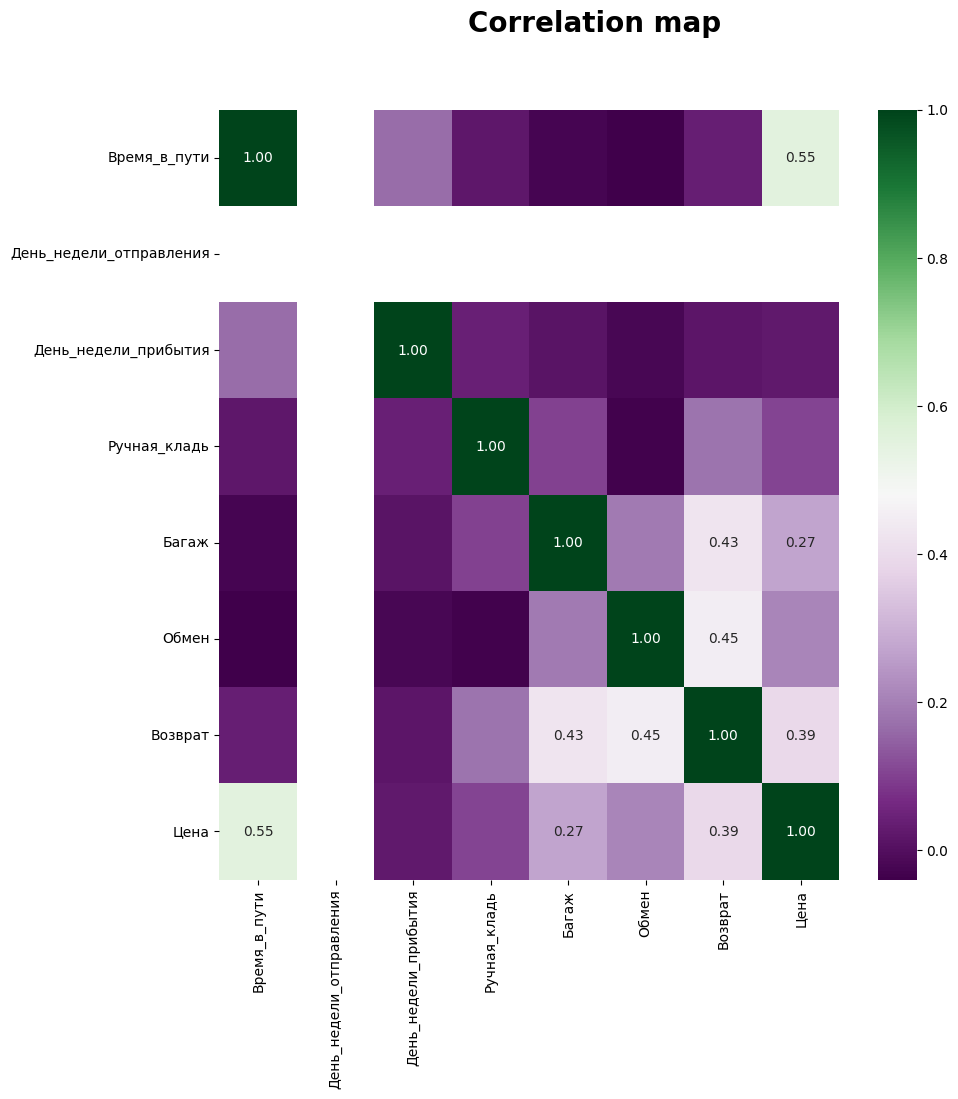

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax_heatmap = plt.subplots(1, 1, figsize=(10, 10))

fig.suptitle('Correlation map', fontsize = 20, weight = 'bold')

ax_heatmap = sns.heatmap(df.corr(numeric_only=True), cmap = 'PRGn', annot=True, fmt="0.2f", ax=ax_heatmap)
for t in ax_heatmap.texts:
    if float(t.get_text()) >= 0.25 or float(t.get_text()) <= -0.25:
        t.set_text(t.get_text())
    else:
        t.set_text("")

plt.show()

/var/folders/xp/hfqkwdyd7cl_l63v11g_d6680000gn/T/ipykernel_3273/1970949944.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax3 = sns.boxplot(data = df, x='Авиакомпания', y='Цена', palette='Pastel1')
/Users/polzovatel/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/polzovatel/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/polzovatel/Library/Python/3.9/lib/python/site-packages/seaborn/_ba

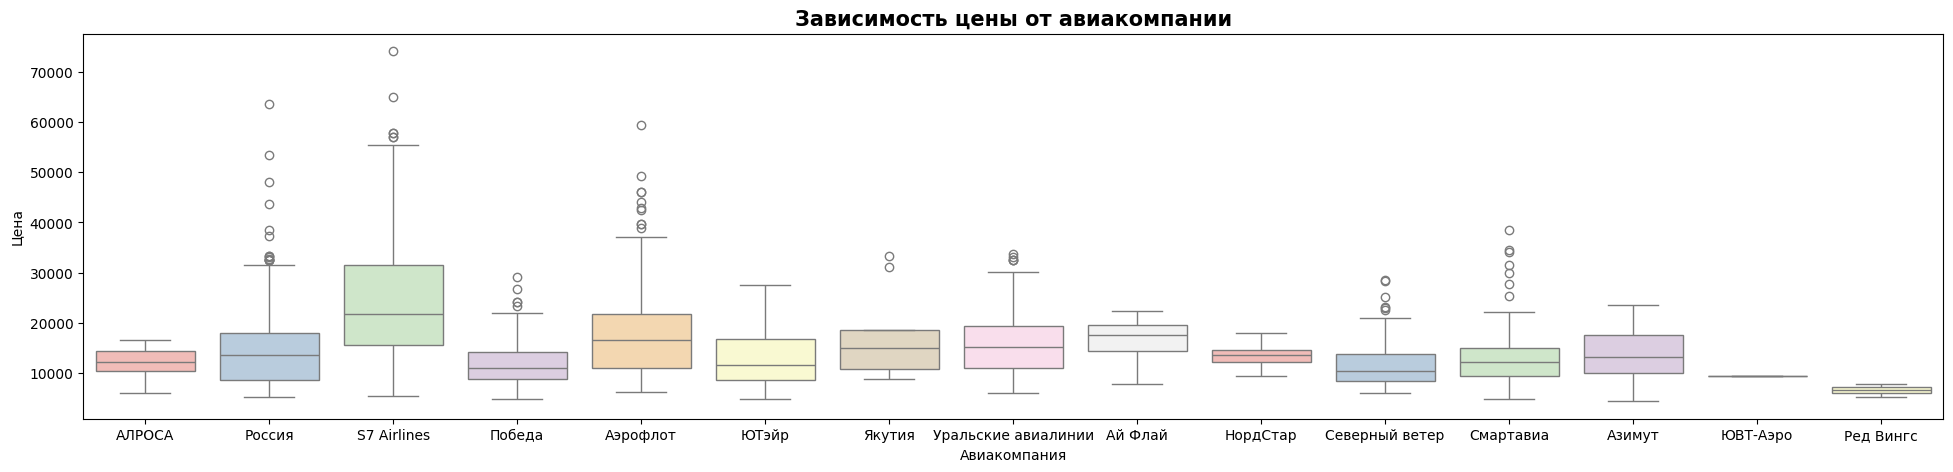

In [21]:
fig, ax3 = plt.subplots(1, 1, figsize=(24, 5))
ax3 = sns.boxplot(data = df, x='Авиакомпания', y='Цена', palette='Pastel1')

ax3.set_ylabel('Цена')
plt.title('Зависимость цены от авиакомпании', weight='bold', fontsize = 15)
plt.show()

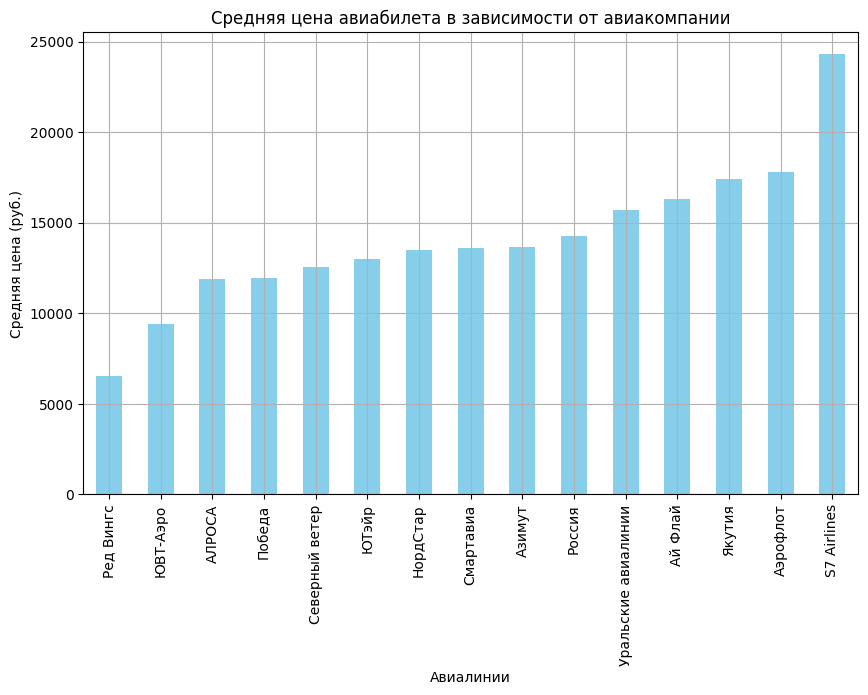

In [22]:
airline_price_avg = df.groupby('Авиакомпания')['Цена'].mean().sort_values()


plt.figure(figsize=(10, 6))
airline_price_avg.plot(kind='bar', color='skyblue')
plt.title('Средняя цена авиабилета в зависимости от авиакомпании')
plt.xlabel('Авиалинии')
plt.ylabel('Средняя цена (руб.)')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


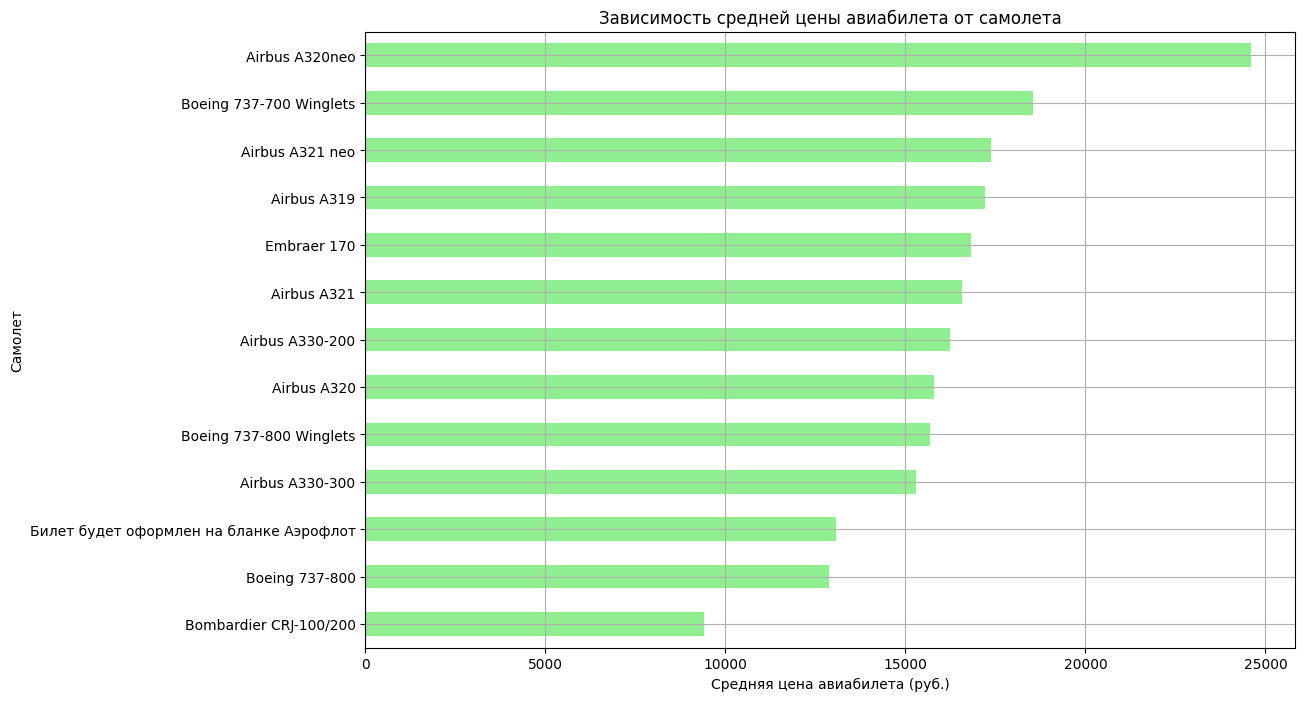

In [23]:

aircraft_price_avg = df.groupby('Самолет')['Цена'].mean().sort_values()


plt.figure(figsize=(12, 8))
aircraft_price_avg.plot(kind='barh', color='lightgreen')
plt.title('Зависимость средней цены авиабилета от самолета')
plt.xlabel('Средняя цена авиабилета (руб.)')
plt.ylabel('Самолет')
plt.grid(True)
plt.show()


In [24]:
df.to_csv('to_release.csv')


/Users/polzovatel/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


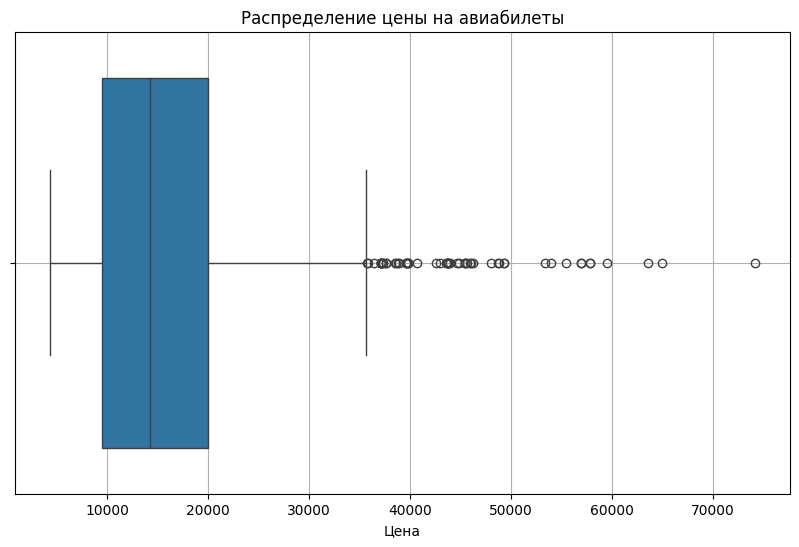

count     1781.000000
mean     16188.111173
std       8747.684322
min       4368.000000
25%       9537.000000
50%      14277.000000
75%      20010.000000
max      74135.000000
Name: Цена, dtype: float64

In [25]:
price_description = df['Цена'].describe()


plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Цена'])
plt.title('Распределение цены на авиабилеты')
plt.xlabel('Цена')
plt.grid(True)
plt.show()

price_description